# Chelan 5: Raster area calculations - whole

Jason MacDonald  
UW Geospatial Data Analysis  
CEE467/CEWA567  
credit to: David Shean  

## Access images

In [1]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
import rasterio as rio
import rasterio.windows
import rasterio.plot
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [3]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar
#for titles
from textwrap import wrap
#for legends
import matplotlib.patches as mpatches

In [4]:
!pip install earthaccess

In [5]:
import earthaccess

auth = earthaccess.login(strategy="netrc")
if not auth:
    auth = earthaccess.login(strategy="interactive", persist=True)
# run single line below if first time
#auth = earthaccess.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 05/10/2023
Using .netrc file for EDL


In [6]:
#Set up directory for output
notebook = 'chelan_5_raster-area-calcs'
path = '/home/jovyan/project/chelanigans/output/%s' %notebook
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [7]:
#access gdf output from query notebook
path = '/home/jovyan/project/chelanigans/output/chelan_0_query-data_2021/gf_lesscloud_20_sentinel.geoJSON'
gf_lesscloud_20_sentinel = gpd.read_file(path)
gf_lesscloud_20_sentinel_df = pd.DataFrame(gf_lesscloud_20_sentinel, columns=('eo:cloud_cover', 'stac_id', 'time', 'platform'))
gf_lesscloud_20_sentinel_df

eo:cloud_cover                             stac_id  \
0                5  HLS.S30.T10UFU.2021062T190301.v2.0   
1               16  HLS.S30.T10UFU.2021092T185921.v2.0   
2                0  HLS.S30.T10UFU.2021107T185909.v2.0   
3                9  HLS.S30.T10UFU.2021142T185921.v2.0   
4                0  HLS.S30.T10UFU.2021152T185921.v2.0   
5                1  HLS.S30.T10UFU.2021172T185921.v2.0   
6                0  HLS.S30.T10UFU.2021177T185919.v2.0   
7                4  HLS.S30.T10UFU.2021187T185919.v2.0   
8                1  HLS.S30.T10UFU.2021192T185921.v2.0   
9               10  HLS.S30.T10UFU.2021207T185919.v2.0   
10               1  HLS.S30.T10UFU.2021267T190029.v2.0   

                               time platform  
0  2021-03-03 19:11:08.571000+00:00        S  
1  2021-04-02 19:11:05.535000+00:00        S  
2  2021-04-17 19:11:04.007000+00:00        S  
3  2021-05-22 19:11:09.221000+00:00        S  
4  2021-06-01 19:11:09.530000+00:00        S  
5  2021-06-21 19:11:09.531000+00:00        S  
6  2021-06-26 19:11:09.416000+00:00        S  
7  2021-07-06 19:11:10.358000+00:00        S  
8  2021-07-11 19:11:11.712000+00:00        S  
9  2021-07-26 19:11:10.637000+00:00        S  
10 2021-09-24 19:11:06.852000+00:00        S

In [8]:
gdf = gf_lesscloud_20_sentinel   
#for cloud, stac_id, time in gdf:
img_list = [stac_id for stac_id in gdf['stac_id']]
date_list = [time.date().strftime('%Y-%m-%d') for time in gdf['time']]
print(date_list, img_list)

['2021-03-03', '2021-04-02', '2021-04-17', '2021-05-22', '2021-06-01', '2021-06-21', '2021-06-26', '2021-07-06', '2021-07-11', '2021-07-26', '2021-09-24'] ['HLS.S30.T10UFU.2021062T190301.v2.0', 'HLS.S30.T10UFU.2021092T185921.v2.0', 'HLS.S30.T10UFU.2021107T185909.v2.0', 'HLS.S30.T10UFU.2021142T185921.v2.0', 'HLS.S30.T10UFU.2021152T185921.v2.0', 'HLS.S30.T10UFU.2021172T185921.v2.0', 'HLS.S30.T10UFU.2021177T185919.v2.0', 'HLS.S30.T10UFU.2021187T185919.v2.0', 'HLS.S30.T10UFU.2021192T185921.v2.0', 'HLS.S30.T10UFU.2021207T185919.v2.0', 'HLS.S30.T10UFU.2021267T190029.v2.0']


In [9]:
#for use with looping through rasters later
# this may not be the best way, stick with above
#gdf = gf_lesscloud_20_sentinel
#date = gdf.time.items()
#img = gdf.stac_id.items()
#date_img = zip(date, img)   
#for d, i in date_img:
#    date = d[1].date()
#    img = i[1]
#    print(date, img)

In [10]:
#Set path to local directory with downloaded images
imgdir = '/home/jovyan/project/chelanigans/data_sample'

## PNW 2021 heatwave dates: June 26 - July 2

In [11]:
#Define image to use (can set this to switch to pre/post heatwave image
img = img_list[-1]
date = date_list[-1]

In [12]:
#Specify filenames for different bands

r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

In [13]:
#Sentinel-2
base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020'
#full_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021362T190811.v2.0/HLS.S30.T10UFU.2021362T190811.v2.0.B02.tif'

#img_list = (img_id2, img_id1)
band_list = ('02', '03', '04', '08','11') 

#Loop through all selected images and bands
#for img in img_list:
for img in img_list:
    for b in band_list:
        #Generate the appropriate URL for the images we identified
        image_url =  '{0}/{1}/{1}.B{2}.tif'.format(base_url, img, b)    
        print(image_url)
    #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
    #Check to see if file already exists
        if not os.path.exists(out_fn):
            print("Saving:", out_fn)
        
        #Download the file
        #figure out authorization here
            #urllib.request.urlretrieve(image_url, out_fn)

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B03.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B08.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B11.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021092T185921.v2.0/HLS.S30.T10UFU.2021092T185921.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.202109

In [14]:
#Sanity check
#Leave these Datasets open for use later in lab (e.g., extracting resolution)
r_src = rio.open(r_fn)
print("MS", r_src.profile)

MS {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 600000.0,
       0.0, -30.0, 5400000.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


## Rasterio window
* Instead of array indexing, we can use the built-in `rasterio.windows.Window` functionality
    * This is really valuable when you only want to load a small portion of a large dataset that is too big to fit into available RAM
        * With array indexing, we must load the entire array into memory and then extract the desired window
        * With the rasterio window, we never have to load the full array
    * https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
    * Syntax is `rasterio.windows.Window(col_offset, row_offset, width, height)`

In [15]:
# Set our rasterio window about Lake Chelan
# used iteration find area of interest

#Lake Chelan
#window = rasterio.windows.Window(1750, 1000, 2048, 2048)
#window = rasterio.windows.Window(2400, 1500, 512, 1024)
#window = rasterio.windows.Window(2400, 1500, 1024, 1024)
#window = rasterio.windows.Window(2400, 1500, 2048, 2048) #error

#window = rasterio.windows.Window(2250, 1500, 512, 512)

#same window shape as chelan geom
window = rasterio.windows.Window(2400, 1500, 1255, 1755)


In [16]:
#NOTE: replaced p_src (opened pancromatic band file) with r_src (red) for the bounds input below
# no pan with Sentinel
# not sure if this is the best solution

#Define window bounds for Pan 
window_bounds = rasterio.windows.bounds(window, r_src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (672000.0, 5302350.0, 709650.0, 5355000.0)
Window extent:  [672000.0, 709650.0, 5302350.0, 5355000.0]


### Function to read only this subwindow into an array

In [17]:
def rio2ma(fn, b=1, window=None, scale=True):
    with rio.open(fn) as src:
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        #If Level 2 surface reflectance and surface temperature, scale values appropriately
        #not needed for this project
        if scale:
            if 'SR' in fn:
                #Output in unitless surface reflectance from 0-1
                a = a * sr_scale + sr_offset
            elif 'ST' in fn:
                #Output in degrees Celsius
                a = a * st_scale + st_offset - 273.15
            a = a.astype('float32')
        return a

### Function to normalize (AKA contrast stretch) input image array values
* The input image pixel values are `UInt16` (unsigned, 16-bit integer, spanning the range 0-65535)
* We want to rescale to `float` values over the range (0.0-1.0)

In [18]:
def normie(data, low_perc, up_perc):
    perc = np.percentile(data.compressed(), (low_perc, up_perc)) #default (2, 98)
    normd = (data - perc[0])/(perc[1] - perc[0])
    clipd = np.clip(normd, 0, 1)
    return clipd

## Natural "true-color" RGB (red, green, blue) composite for this window
* This represents "true" color, closer to what your eye would see
* Use the `rio2ma` function to load the same window from the red, green and blue band tif files
    * ⚠️ Make sure you pass in the window, and don't try to load the full images here!  Can potentially fill RAM on your Jupyterhub server, leading to kernel restart!
* Then normalize each channel independently using your `norm` function
    * Note: the surface reflectance values for Bands 1-7 (visible and near-IR) should already be scaled from 0.0-1.0 due to scaling in the original `rio2ma` function at the beginning of the notebook

ERROR 1: TIFFFillTile:Read error at row 2816, col 2816, tile 192; got 0 bytes, expected 93782
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: /home/jovyan/project/chelanigans/data_sample/HLS.S30.T10UFU.2021192T185921.v2.0.B03.tif, band 1: IReadBlock failed at X offset 12, Y offset 12: TIFFReadEncodedTile() failed.


RasterioIOError: Read or write failed. /home/jovyan/project/chelanigans/data_sample/HLS.S30.T10UFU.2021192T185921.v2.0.B03.tif, band 1: IReadBlock failed at X offset 12, Y offset 12: TIFFReadEncodedTile() failed.

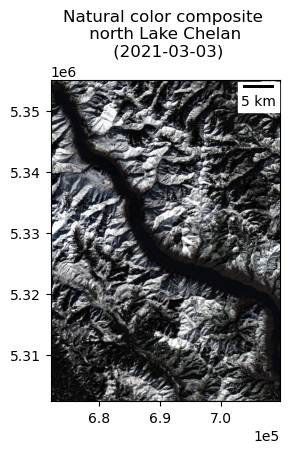

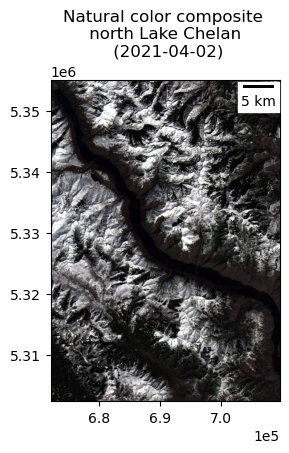

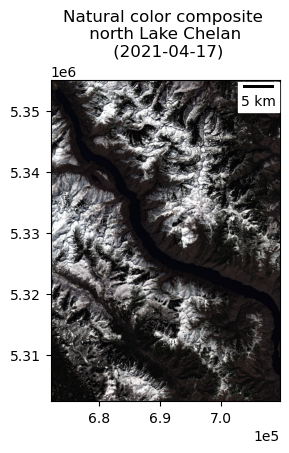

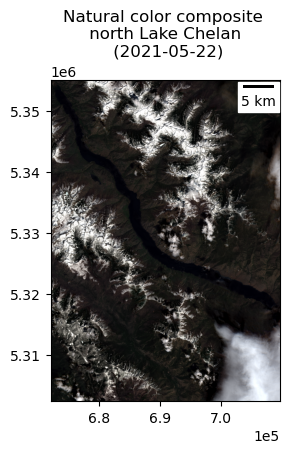

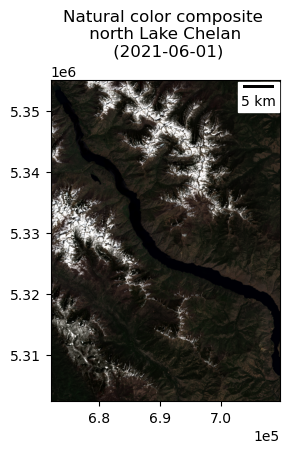

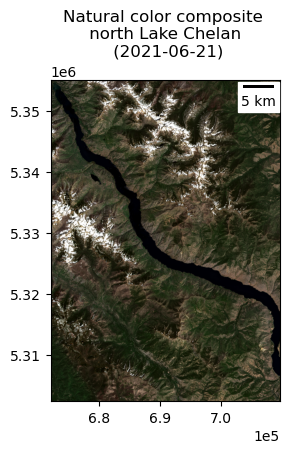

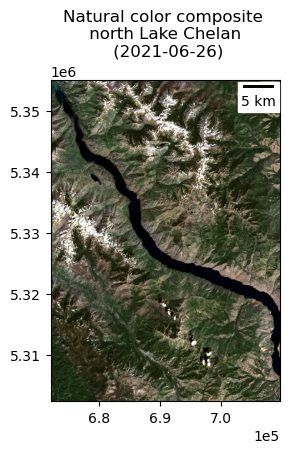

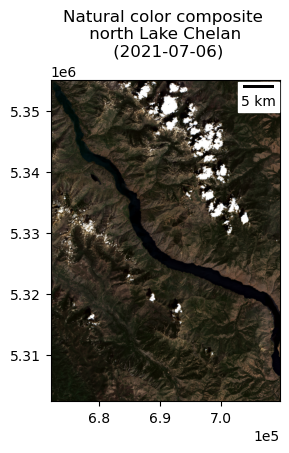

In [19]:
# plotting individual figures for each date

for i in enumerate(img_list):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])

    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, str(img)+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, str(img)+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, str(img)+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, str(img)+'.B08.tif') #Near-Infrared (NIR08)
    swir_fn = os.path.join(imgdir, str(img)+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    r = rio2ma(r_fn, b=1, window=window, scale=True)
    g = rio2ma(g_fn, b=1, window=window, scale=True)
    b = rio2ma(b_fn, b=1, window=window, scale=True)

    r_norm = normie(r, 2, 98)
    g_norm = normie(g, 2, 98)
    b_norm = normie(b, 2, 98)

    fin = np.dstack((r_norm,g_norm,b_norm))

    fig, ax = plt.subplots(figsize=(3,6))

    #ax.imshow(fin, cmap='gray', extent=window_extent)
    ax.imshow(fin, extent=window_extent)

    ax.add_artist(ScaleBar(1.0))
    ax.ticklabel_format(scilimits=(1,3))
    ax.set_title(('Natural color composite \n north Lake Chelan \n (%s)' %date), y=1.05)
    plt.tight_layout()

    #save image output
    strFile = ('/home/jovyan/project/chelanigans/output/%s/natural-color-comp_%s.png' %(notebook, date))
    if os.path.isfile(strFile):
        #os.remove(strFile)
        os.system("rm "+strFile)
    plt.savefig(strFile);

ERROR 1: TIFFFillTile:Read error at row 2816, col 2816, tile 192; got 0 bytes, expected 93782
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: /home/jovyan/project/chelanigans/data_sample/HLS.S30.T10UFU.2021192T185921.v2.0.B03.tif, band 1: IReadBlock failed at X offset 12, Y offset 12: TIFFReadEncodedTile() failed.


RasterioIOError: Read or write failed. /home/jovyan/project/chelanigans/data_sample/HLS.S30.T10UFU.2021192T185921.v2.0.B03.tif, band 1: IReadBlock failed at X offset 12, Y offset 12: TIFFReadEncodedTile() failed.

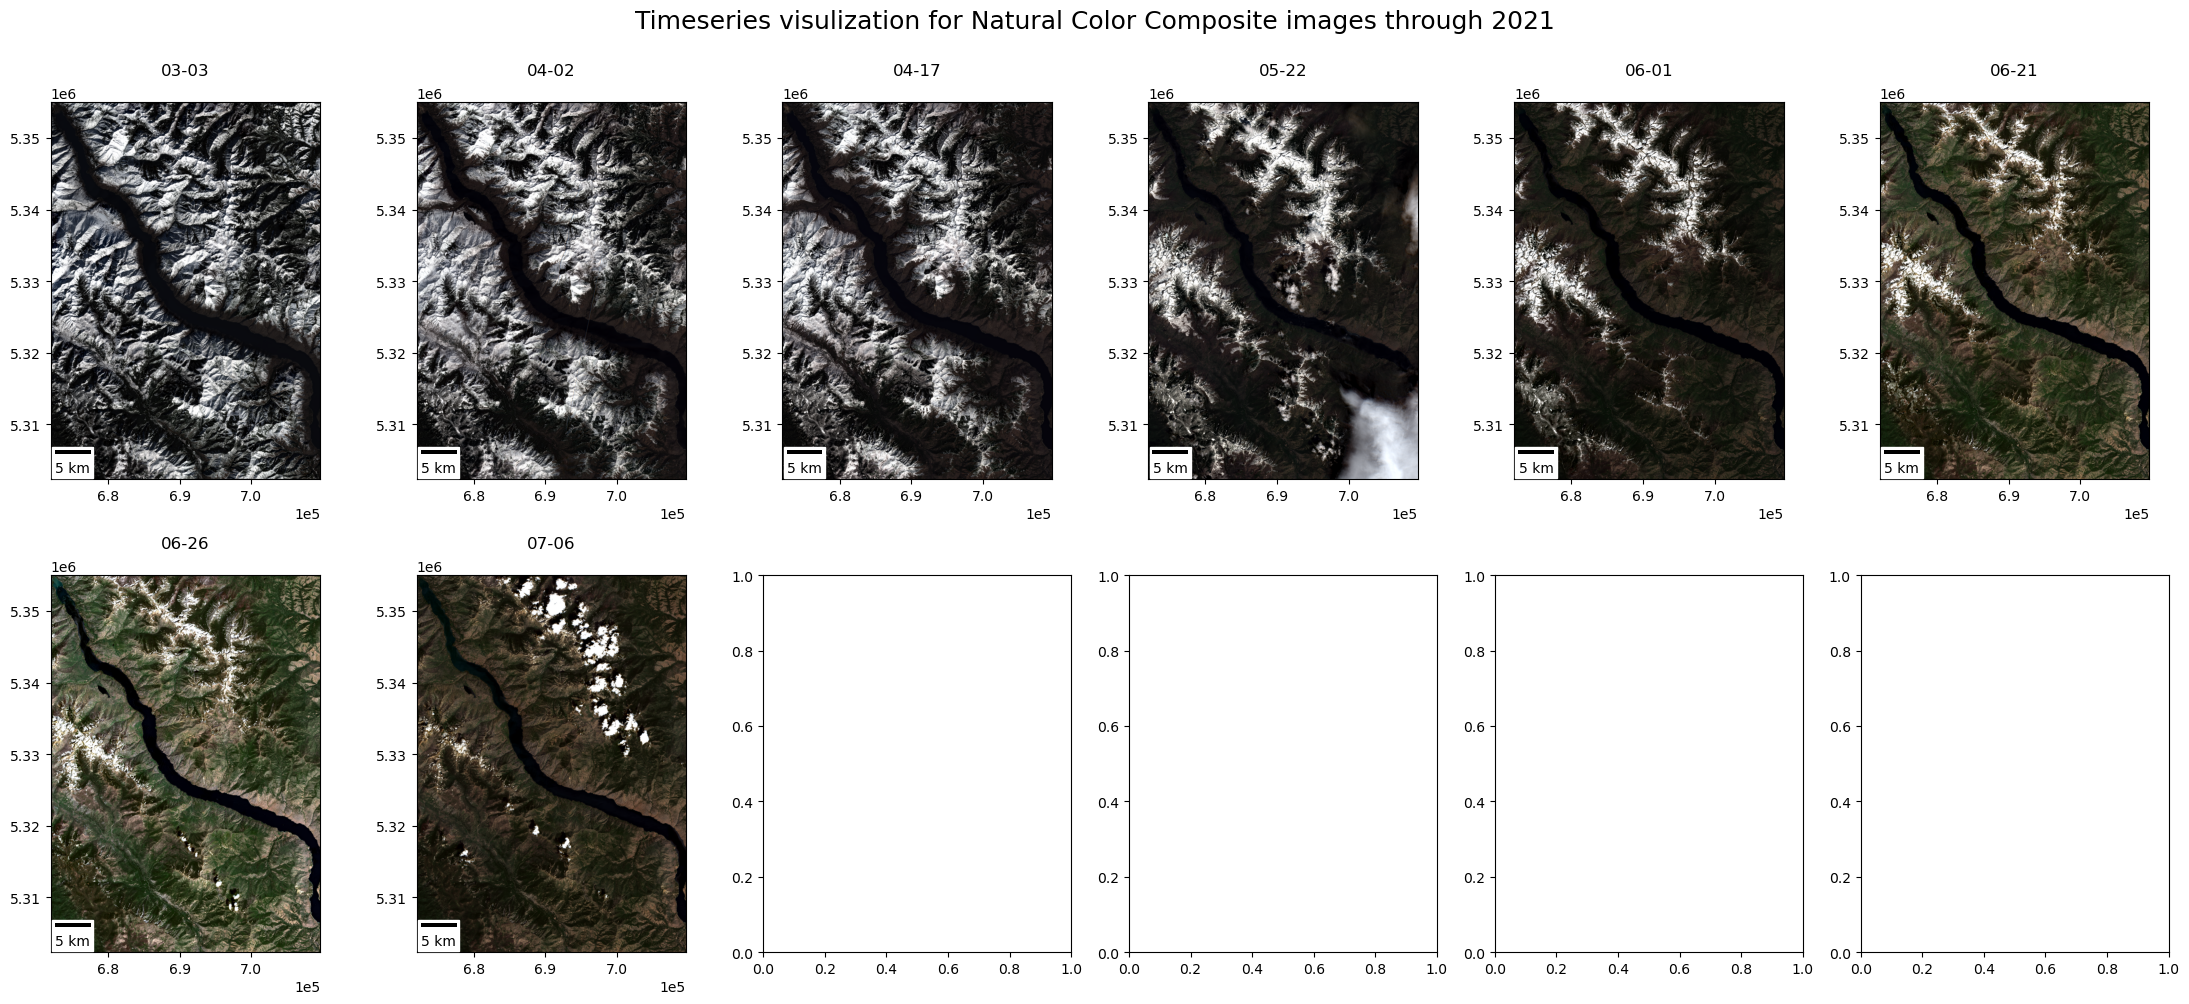

In [20]:
# natural color composition timeseries 
fig, axa = plt.subplots(2, 6, figsize=(22, 10), edgecolor='k')
#plt.figure(figsize=(18, 12), edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=.5)
fig.suptitle('Timeseries visulization for Natural Color Composite images through %s' %date[0:4],
             fontsize=18,
             y=1)    

axa = axa.ravel()

for i in enumerate(img_list):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])
    
    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    r = rio2ma(r_fn, b=1, window=window, scale=True)
    g = rio2ma(g_fn, b=1, window=window, scale=True)
    b = rio2ma(b_fn, b=1, window=window, scale=True)

    r_norm = normie(r, 2, 98)
    g_norm = normie(g, 2, 98)
    b_norm = normie(b, 2, 98)

    fin = np.dstack((r_norm,g_norm,b_norm))

    #ax.imshow(fin, cmap='gray', extent=window_extent)
    axa[index].imshow(fin, extent=window_extent)

    axa[index].add_artist(ScaleBar(1.0, location='lower left'))
    axa[index].ticklabel_format(scilimits=(1,3))
    axa[index].set_title(date[5:10], y=1.05)
    plt.tight_layout()
    
fig.delaxes(axa[-1])
#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/natural-color-comp-timeseries.png' %(notebook))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

## Clip data to Lake Chelan polygon

In [21]:
#wa_lakes_gjson_url = '#https://geo.wa.gov/datasets/WSDOT::wsdot-major-lakes-1500k/explore?filters=eyJOQU1FIjpbIkxha2UgQ2hlbGFuIl19&location=48.085597%2C-120.767080%2C9.89'
wa_lakes_gjson_url = '/home/jovyan/project/chelanigans/data_sample/WSDOT_-_Major_Lakes_(1%3A500K).geojson'
wa_lakes_gjson_gdf = gpd.read_file(wa_lakes_gjson_url) #just pointing to downloaded file for now
#Reproject to match raster
wa_lakes_gjson_gdf_proj = wa_lakes_gjson_gdf.to_crs(r_src.crs)
#Isolate Lake Chelan
chelan_gjson_iso = wa_lakes_gjson_gdf_proj.loc[wa_lakes_gjson_gdf_proj['NAME'] == 'Lake Chelan']
#Extract geometry to use for clipping
chelan_geom = chelan_gjson_iso.iloc[0].geometry

In [22]:
#Pass this in to the `rio.mask.mask` call (see demo)
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
#must pass chelan_geom polygon as list because rio.mask.mask expects multipolygon
chelan_mask, chelan_mask_transform = rio.mask.mask(r_src, [chelan_geom,], **rio_mask_kwargs)

In [23]:
#Get clipped extent in UTM coordinates
chelan_mask_extent = rio.plot.plotting_extent(chelan_mask, chelan_mask_transform)
chelan_mask_extent

(672150.0, 709800.0, 5302170.0, 5354820.0)

## NDTI (normalized difference turbidity index)  
### Timeseries analysis  

[4] C. Baughman et al

In [24]:
#%matplotlib widget
%matplotlib inline

ERROR 1: TIFFFillTile:Read error at row 2816, col 2816, tile 192; got 0 bytes, expected 93782
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: /home/jovyan/project/chelanigans/data_sample/HLS.S30.T10UFU.2021192T185921.v2.0.B03.tif, band 1: IReadBlock failed at X offset 12, Y offset 12: TIFFReadEncodedTile() failed.


RasterioIOError: Read or write failed. /home/jovyan/project/chelanigans/data_sample/HLS.S30.T10UFU.2021192T185921.v2.0.B03.tif, band 1: IReadBlock failed at X offset 12, Y offset 12: TIFFReadEncodedTile() failed.

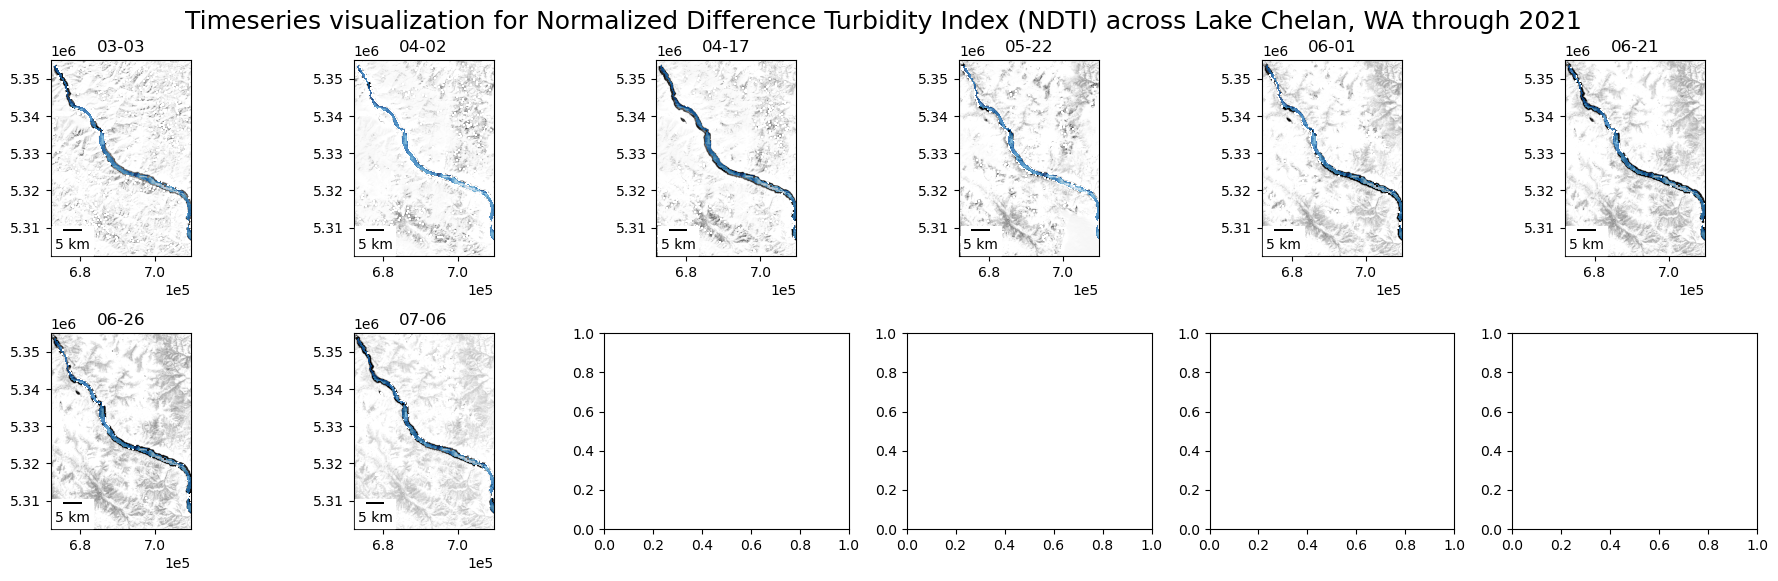

In [25]:
fig, axa = plt.subplots(2, 6, figsize=(18, 6), edgecolor='k')
#plt.figure(figsize=(18, 12), edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=.5)
fig.suptitle('Timeseries visualization for Normalized Difference Turbidity Index (NDTI) across Lake Chelan, WA through %s' %date[0:4],
             fontsize=18,
             y=.96)    

axa = axa.ravel()

for i in enumerate(img_list):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])

    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    r = rio2ma(r_fn, b=1, window=window, scale=True)
    g = rio2ma(g_fn, b=1, window=window, scale=True)
    #b = rio2ma(b_fn, b=1, window=window, scale=True)
    #nir = rio2ma(nir_fn, b=1, window=window, scale=True)
    
    #set our index variables for 
    #normalized difference turbidity index
    ndti = (r - g) / (r + g)
    #normalized difference suspended solids index
    #ndssi = (b - nir) / (b + nir)

    #clip
    ndti = np.ma.clip(ndti, -1, 0)
    #ndssi = np.ma.clip(ndssi, -1, 0)
    
#    axa[index] = plt.subplots(2, 5)
    
    #plot NDTI
    axa[index].imshow(normie(ndti, 2, 98), extent=window_extent, cmap='gray')
    shw0 = axa[index].imshow(chelan_mask, cmap='Blues_r', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=64)
#    bar = plt.colorbar(shw0, shrink=.7, label= "Elevation (m HAE)")
    axa[index].add_artist(ScaleBar(1.0, location='lower left'))
    axa[index].set_title(date[5:10])
    axa[index].ticklabel_format(scilimits=(1,3))
    axa[index].set_xlim(window_extent[0], window_extent[1])
    axa[index].set_ylim(window_extent[2], window_extent[3])    
    
    plt.tight_layout()
    
fig.delaxes(axa[-1])
bar = plt.colorbar(shw0, ax=axa[-1], location='left', shrink=0.9, label="Normalized Difference Turbidity Index")
#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/NDTI_timeseries.png' %(notebook))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

## NDSSI (normalized difference suspended sediment index)  
### Timeseries analysis  

[11] Hossain et al

In [ ]:
fig, axa = plt.subplots(2, 6, figsize=(18, 6), edgecolor='k')
#plt.figure(figsize=(18, 12), edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=.5)
fig.suptitle('Timeseries visulization for Normalized Difference Suspended Solids Index (NDSSI) across Lake Chelan, WA through %s' %date[0:4],
             fontsize=18,
             y=1)    

axa = axa.ravel()

for i in enumerate(img_list):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])

    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    #r = rio2ma(r_fn, b=1, window=window, scale=True)
    #g = rio2ma(g_fn, b=1, window=window, scale=True)
    b = rio2ma(b_fn, b=1, window=window, scale=True)
    nir = rio2ma(nir_fn, b=1, window=window, scale=True)
    
    #set our index variables for 
    #normalized difference turbidity index
    #ndti = (r - g) / (r + g)
    #normalized difference suspended solids index
    ndssi = (b - nir) / (b + nir)

    #clip
    #ndti = np.ma.clip(ndti, -1, 0)
    ndssi = np.ma.clip(ndssi, -1, 0)
    
#    axa[index] = plt.subplots(2, 5)
    
    #plot NDTI
    axa[index].imshow(normie(ndssi, 2, 98), extent=window_extent, cmap='gray')
    shw0 = axa[index].imshow(chelan_mask, cmap='Blues_r', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=60)
#    bar = plt.colorbar(shw0, shrink=.7, label= "Elevation (m HAE)")
    axa[index].add_artist(ScaleBar(1.0, location='lower left'))
    axa[index].set_title(date[5:10])
    axa[index].ticklabel_format(scilimits=(1,3))
    axa[index].set_xlim(window_extent[0], window_extent[1])
    axa[index].set_ylim(window_extent[2], window_extent[3])    
    
    plt.tight_layout()
    
fig.delaxes(axa[-1])
bar = plt.colorbar(shw0, ax=axa[-1], location='left', shrink=0.9, label="NDSSI")
#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/NDSSI_timeseries.png' %(notebook))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

## Comparison of NDTI vs NDSSI

In [ ]:
for i in enumerate(img_list):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])
    
    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    r = rio2ma(r_fn, b=1, window=window, scale=True)
    g = rio2ma(g_fn, b=1, window=window, scale=True)
    b = rio2ma(b_fn, b=1, window=window, scale=True)
    nir = rio2ma(nir_fn, b=1, window=window, scale=True)
    
    
    
    #set our index variables for 
    #normalized difference turbidity index
    ndti = (r - g) / (r + g)
    #normalized difference suspended solids index
    ndssi = (b - nir) / (b + nir)

    #clip
    ndti = np.ma.clip(ndti, -1, 0)
    ndssi = np.ma.clip(ndssi, -1, 0)
    
    #set each figure
    fig, axa = plt.subplots(1, 2, figsize=(5,3), sharex=True, sharey=True)
    
    #plot NDTI
    axa[0].imshow(normie(ndti, 2, 98), extent=window_extent, cmap='gray')
    shw0 = axa[0].imshow(chelan_mask, cmap='Blues_r', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=24)
    bar = plt.colorbar(shw0)
    axa[0].add_artist(ScaleBar(1.0, location='lower left'))
    axa[0].set_title('NDTI')
    axa[0].ticklabel_format(scilimits=(1,3))
    axa[0].set_xlim(window_extent[0], window_extent[1])
    axa[0].set_ylim(window_extent[2], window_extent[3])
    
    #plot NDSSI
    axa[1].imshow(normie(ndssi, 2, 98), extent=window_extent, cmap='gray')
    shw0 = axa[1].imshow(chelan_mask, cmap='Blues_r', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=24)
    bar = plt.colorbar(shw0)
    axa[1].set_title('NDSSI')
    axa[1].ticklabel_format(scilimits=(1,3))
    axa[1].set_xlim(window_extent[0], window_extent[1])
    axa[1].set_ylim(window_extent[2], window_extent[3])

    fig.suptitle(('Normalized Difference Turbidity Index vs \n Normalized Difference Suspended Solids Index \n (%s)' %date),
                 y=1.03)
    plt.tight_layout()
    
    #save output
    strFile = ('/home/jovyan/project/chelanigans/output/%s/ndti-vs-ndssi_%s.png' %(notebook, date))
    if os.path.isfile(strFile):
        #os.remove(strFile)
        os.system("rm "+strFile)
    plt.savefig(strFile);

## RGB individual bands
### Timeseries analysis

In [ ]:
for i in enumerate(img_list):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])
    
    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    r = rio2ma(r_fn, b=1, window=window, scale=True)
    g = rio2ma(g_fn, b=1, window=window, scale=True)
    b = rio2ma(b_fn, b=1, window=window, scale=True)

    fig, axa = plt.subplots(1, 3, figsize=(8,3), sharex=True, sharey=True)

    axa[0].imshow(r, extent=window_extent, cmap='gray')
    shw0 = axa[0].imshow(chelan_mask, cmap='Reds', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=64)
    bar = plt.colorbar(shw0)
    axa[0].add_artist(ScaleBar(1.0, location='lower left'))
    axa[0].set_title('Red band')
    axa[0].ticklabel_format(scilimits=(1,3))
    axa[0].set_xlim(window_extent[0], window_extent[1])
    axa[0].set_ylim(window_extent[2], window_extent[3])

    axa[1].imshow(g, extent=window_extent, cmap='gray')
    shw1 = axa[1].imshow(chelan_mask, cmap='Greens', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=64)
    bar = plt.colorbar(shw1)
    axa[1].add_artist(ScaleBar(1.0, location='lower left'))
    axa[1].set_title('Green band')
    axa[1].ticklabel_format(scilimits=(1,3))
    axa[1].set_xlim(window_extent[0], window_extent[1])
    axa[1].set_ylim(window_extent[2], window_extent[3])

    axa[2].imshow(b, extent=window_extent, cmap='gray')
    shw2 = axa[2].imshow(chelan_mask, cmap='Blues', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=64)
    bar = plt.colorbar(shw2)
    axa[2].add_artist(ScaleBar(1.0, location='lower left'))
    axa[2].set_title('Blue band')
    axa[2].ticklabel_format(scilimits=(1,3))
    axa[2].set_xlim(window_extent[0], window_extent[1])
    axa[2].set_ylim(window_extent[2], window_extent[3])

    fig.suptitle(('Intensity of individual RGB bands for north Lake Chelan, WA (%s)' %date),
                 y=.96)
    plt.tight_layout()

    strFile = ('/home/jovyan/project/chelanigans/output/%s/rgb_masked_%s.png' %(notebook, date))
    if os.path.isfile(strFile):
        #os.remove(strFile)
        os.system("rm "+strFile)
    plt.savefig(strFile);

## Raster Classification Using Threshold
### Create binary NDTI and NDSSI masks
* Need to define a cutoff value (threshold) for NDVI values to define a boolean vegetation mask
    * NDTI/NDSSI values above this threshold will be classified as "turbidity" and "ss" respectively
    * NDTI/NDSSI values below this threshold will be classified as "not turbidity" and "not ss" respectively
* To decide on a threshold, plot a histogram of NDTI/NDSSI values

In [30]:
thresh_ndti = -0.35

In [31]:
fig, axa = plt.subplots(1,2)
fig.suptitle('Histograms of indice values for ough %s' %date[0:4],
             fontsize=18,
             y=.95)   

axa[0].hist(ndti.compressed().ravel(), bins=256, color='violet', log=False)

axa[0].axvline(thresh_ndti, ls='--', c='g', label=thresh_ndti)
axa[0].set_ylim(0,15000)

axa[0].legend()
axa[0].set_ylabel('Number of occurences')
axa[0].set_xlabel('NDTI values')
axa[0].set_title('Histogram of NDTI values within north Lake Chelan window')

axa[1].hist(ndti.compressed().ravel(), bins=256, color='violet', log=False)

axa[1].axvline(thresh_ndti, ls='--', c='g', label=thresh_ndti)
axa[1].set_ylim(0,15000)

axa[1].legend()
axa[1].set_ylabel('Number of occurences')
axa[1].set_xlabel('NDTI values')
axa[1].set_title('Histogram of NDSSI values within north Lake Chelan window');

SyntaxError: invalid syntax (818848042.py, line 24)

In [32]:
# create dataframe to store timeseries analysis
chelan_df = []
NDTI_area_ls = []

chelan_df = pd.DataFrame(img_list[::])
chelan_df.rename({0:'img'}, axis=1, inplace=True)
#chelan_df['img'] = img_list[::]
chelan_df['date'] = date_list[::]

#chelan_df = img_list.append(date_list)
chelan_df.head()

img        date
0  HLS.S30.T10UFU.2021062T190301.v2.0  2021-03-03
1  HLS.S30.T10UFU.2021092T185921.v2.0  2021-04-02
2  HLS.S30.T10UFU.2021107T185909.v2.0  2021-04-17
3  HLS.S30.T10UFU.2021142T185921.v2.0  2021-05-22
4  HLS.S30.T10UFU.2021152T185921.v2.0  2021-06-01

ERROR 1: TIFFFillTile:Read error at row 2816, col 2816, tile 192; got 0 bytes, expected 93782
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: /home/jovyan/project/chelanigans/data_sample/HLS.S30.T10UFU.2021192T185921.v2.0.B03.tif, band 1: IReadBlock failed at X offset 12, Y offset 12: TIFFReadEncodedTile() failed.


RasterioIOError: Read or write failed. /home/jovyan/project/chelanigans/data_sample/HLS.S30.T10UFU.2021192T185921.v2.0.B03.tif, band 1: IReadBlock failed at X offset 12, Y offset 12: TIFFReadEncodedTile() failed.

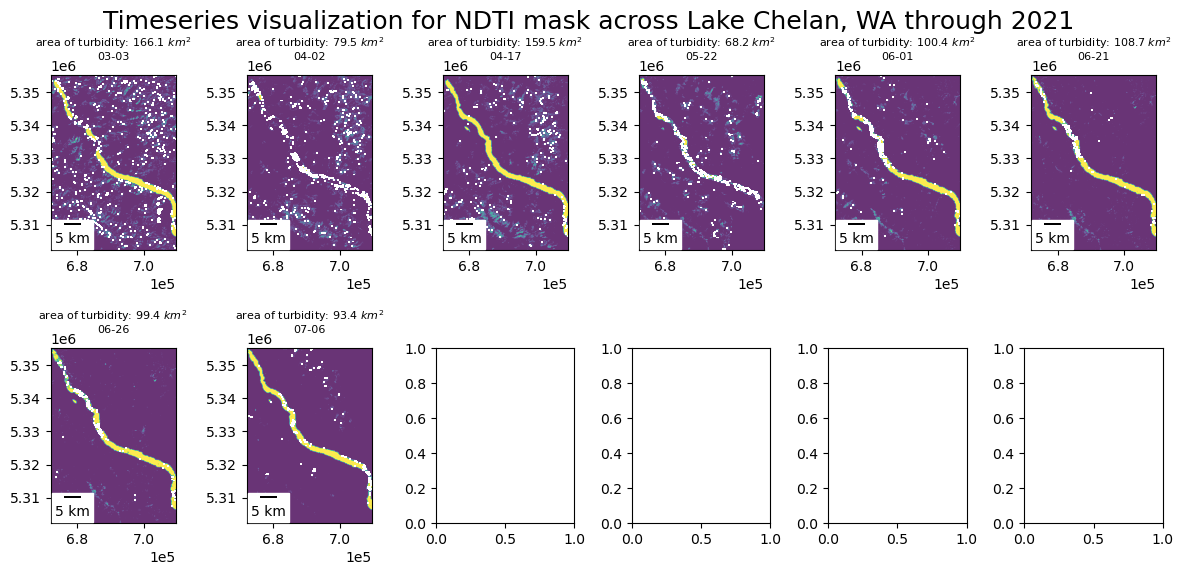

In [33]:
fig, axa = plt.subplots(2, 6, figsize=(12, 6), edgecolor='k')
#plt.figure(figsize=(18, 12), edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=.5)
fig.suptitle('Timeseries visualization for NDTI mask across Lake Chelan, WA through %s' %date[0:4],
             fontsize=18,
             y=.95)    

axa = axa.ravel()

for i in enumerate(img_list[0:11]):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])

    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    r = rio2ma(r_fn, b=1, window=window, scale=True)
    g = rio2ma(g_fn, b=1, window=window, scale=True)
    #b = rio2ma(b_fn, b=1, window=window, scale=True)
    #nir = rio2ma(nir_fn, b=1, window=window, scale=True)
    
    #set our index variables for 
    #normalized difference turbidity index
    ndti = (r - g) / (r + g)
    #normalized difference suspended solids index
    #ndssi = (b - nir) / (b + nir)

    #clip
    ndti = np.ma.clip(ndti, -1, 0)
    #ndssi = np.ma.clip(ndssi, -1, 0)
    
    ndti_chelan = ndti<=thresh_ndti
    
    truths = ndti_chelan.sum()
    turb = truths * 0.03 * 0.03
    area_of_turb = ('area of turbidity: %.1f $km^2$' %turb)
    NDTI_area_ls.append(round(turb,2))
    
    #plot NDTI
    #axa[index].imshow(chelan_mask, extent=chelan_mask_extent, cmap='gray')
    axa[index].imshow(ndti_chelan, extent=window_extent, alpha=0.8, vmin=0, vmax=1)
    
    axa[index].add_artist(ScaleBar(1.0, location='lower left'))
    axa[index].set_title(area_of_turb+'\n'+date[5:10], fontsize=8, y=1.04)
    axa[index].ticklabel_format(scilimits=(1,3))
    axa[index].set_xlim(window_extent[0], window_extent[1])
    axa[index].set_ylim(window_extent[2], window_extent[3])    
    
    plt.tight_layout()

snow_legend = mpatches.Patch(color='yellow', label='snow')
axa[-1].legend(handles=[snow_legend], loc='lower right', shadow=True, fancybox=True)

fig.delaxes(axa[-1])

chelan_df['NDSSI_area'] = NDTI_area_ls[::]

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/NDTI_thresh_timeseries.png' %(notebook))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

In [ ]:
fig, axa = plt.subplots(2, 6, figsize=(12, 6), edgecolor='k')
#plt.figure(figsize=(18, 12), edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=.5)
fig.suptitle('Timeseries visualization for NDSSI mask across Lake Chelan, WA through %s' %date[0:4],
             fontsize=18,
             y=.95)    

axa = axa.ravel()

for i in enumerate(img_list[0:11]):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])

    #Specify filenames for different bands
    #r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    #g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    #swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    #r = rio2ma(r_fn, b=1, window=window, scale=True)
    #g = rio2ma(g_fn, b=1, window=window, scale=True)
    b = rio2ma(b_fn, b=1, window=window, scale=True)
    nir = rio2ma(nir_fn, b=1, window=window, scale=True)
    
    #set our index variables for 
    #normalized difference turbidity index
    #ndti = (r - g) / (r + g)
    #normalized difference suspended solids index
    ndssi = (b - nir) / (b + nir)

    #clip
    #ndti = np.ma.clip(ndti, -1, 0)
    ndssi = np.ma.clip(ndssi, -1, 0)
    
    ndti_chelan = ndti<=thresh_ndti
    ndssi_chelan = ndssi<=thresh_ndssi
    
    truths = ndssi_chelan.sum()
    turb = truths * 0.03 * 0.03
    area_of_turb = ('area of turbidity: %.1f $km^2$' %turb)
    NDSSI_area_ls.append(round(turb,2))
    
    #plot NDTI
    #axa[index].imshow(chelan_mask, extent=chelan_mask_extent, cmap='gray')
    axa[index].imshow(ndssi_chelan, extent=window_extent, alpha=0.8, vmin=0, vmax=1)
    
    axa[index].add_artist(ScaleBar(1.0, location='lower left'))
    axa[index].set_title(area_of_turb+'\n'+date[5:10], fontsize=8, y=1.04)
    axa[index].ticklabel_format(scilimits=(1,3))
    axa[index].set_xlim(window_extent[0], window_extent[1])
    axa[index].set_ylim(window_extent[2], window_extent[3])    
    
    plt.tight_layout()

snow_legend = mpatches.Patch(color='yellow', label='NDSSI>$.2f' $thresh_ndssi)
axa[-1].legend(handles=[snow_legend], loc='lower right', shadow=True, fancybox=True)

fig.delaxes(axa[-1])

chelan_df['NDSSI_area'] = NDSSI_area_ls[::]

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/NDSSI_thresh_timeseries.png' %(notebook))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

In [ ]:
chelan_df.plot()